In [1]:
#Here the goal is to embedd SMILES; for which i need to tokenize the SMILES first ; let's do it

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os
os.getcwd()

'C:\\Users\\sunoj'

In [4]:
df=pd.read_csv('curated_smiles.csv')

In [6]:
df.head(3)

,smiles
0,CC1(OC(C(O1)CO)CO)C
1,CC1(OC(C(O1)C(C2=CC=CC=C2)(C3=CC=CC=C3)O)C(C4=...
2,CC1=CC23C(CC1)(C4(CC(C(C4(O2)CO)O3)O)C)C


In [7]:
df.shape

(4127, 1)

In [13]:
#remove the SMILES with length higher than 80
condition=[len(i) <80 for i in df['smiles']]

In [14]:
df_filterd=df[condition]

In [15]:
df_filterd.shape #so (4127-4111)=16 molecules/SMILES are removed

(4111, 1)

In [16]:
def smiles2one_hot_chars(smi_list):
    # get all the characters
    char_lists = [list(smi) for smi in smi_list]
    chars = list(set([char for sub_list in char_lists for char in sub_list]))
    chars.append(' ')
    return chars

In [25]:
vocab=smiles2one_hot_chars(df_filterd['smiles'])

In [26]:
print(vocab)

['N', 'S', 'l', '6', '#', 'H', '4', ']', '3', '1', 'I', 'O', '[', 'r', '(', '=', 'i', ')', '9', '7', 'F', 'B', 'C', '8', '5', 'P', '2', ' ']


In [38]:
vocab_size=len(vocab)
print(vocab_size)

28


In [39]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(vocab_size, filters='', char_level=True)

In [40]:
tokenizer.fit_on_texts(df_filterd['smiles'])

In [41]:
type(tokenizer)

keras_preprocessing.text.Tokenizer

In [43]:
seqs=tokenizer.texts_to_sequences(df_filterd.smiles)

In [44]:
#check the sequences
print(seqs[0])

[1, 1, 5, 3, 7, 1, 3, 1, 3, 7, 5, 4, 1, 7, 4, 1, 7, 4, 1]


In [48]:
print(len(seqs[0]))
print(len(seqs[50])) #Note that all SMILES are of different length

19
28


In [49]:
#so i need to padd them

In [50]:
padded_seqs=tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

In [51]:
#check it 
padded_seqs #so all SMILES are of same length now

array([[1, 1, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       ...,
       [1, 1, 5, ..., 0, 0, 0],
       [1, 7, 1, ..., 0, 0, 0],
       [1, 7, 1, ..., 0, 0, 0]])

In [87]:
len(padded_seqs[5])

79

In [52]:
#Let's calculate some feature using rdkit and predict it

In [56]:
from rdkit import Chem
from rdkit.Chem import Descriptors

In [58]:
mols=[Chem.MolFromSmiles(i) for i in df_filterd['smiles']]

In [76]:
tpsa=[Descriptors.TPSA(i) for i in mols]

In [80]:
df_filterd['tpsa']=tpsa

C:\Users\sunoj\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
#okay lets not build any model
#just only embedding layer

In [88]:
embedding_layer=layers.Embedding(28, 5, input_length=79)

In [115]:
result=embedding_layer(padded_seqs)

In [116]:
result.shape

TensorShape([4111, 79, 5])

In [143]:
#uncomment this to check the embedded smiles
#result.numpy() 

In [95]:
#okay build a model

In [97]:
padded_seqs

array([[1, 1, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       ...,
       [1, 1, 5, ..., 0, 0, 0],
       [1, 7, 1, ..., 0, 0, 0],
       [1, 7, 1, ..., 0, 0, 0]])

In [137]:
model=keras.Sequential()
model.add(layers.Embedding(28, 5, input_length=79))
#the embedding layer will give a tensor of shape (79, 5); I need to flatten it
model.add(layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 79, 5)             140       
_________________________________________________________________
flatten_3 (Flatten)          (None, 395)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               101376    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 118,029
Trainable params: 118,029
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.compile('adam', loss='mean_squared_error', metrics=['mse'])
result=model.fit(padded_seqs, df_filterd['tpsa'], epochs=5)

Epoch 1/5
129/129 [==============================] - 1s 1ms/step - loss: 2413.9907 - mse: 2413.9907
Epoch 2/5
129/129 [==============================] - 0s 1ms/step - loss: 2411.9751 - mse: 2411.9751
Epoch 3/5
129/129 [==============================] - 0s 1ms/step - loss: 2411.9744 - mse: 2411.9744
Epoch 4/5
129/129 [==============================] - 0s 1ms/step - loss: 2411.9744 - mse: 2411.9744
Epoch 5/5
129/129 [==============================] - 0s 1ms/step - loss: 2411.9736 - mse: 2411.9736


In [139]:
from math import sqrt
sqrt(2411.9746)

49.111858038563355

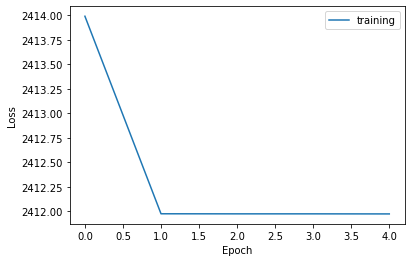

In [140]:
import matplotlib.pyplot as plt
plt.plot(result.history['loss'], label='training')
#plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [142]:
model.predict(padded_seqs[0:5])

array([[0.99998856],
       [0.9999894 ],
       [0.9999895 ],
       [0.9999893 ],
       [0.99998873]], dtype=float32)